In [1]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [100]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


# param setting

In [101]:
EPOCHS = 100
LR = 1e-3
BS = 16
SEED = 42
WINDOW_SIZE = 30
KERNEL_SIZE = 5
STRIDE = 1
MODEL_NAME ='lstm_model_type'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# Data loading

In [102]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

# Data scaling

In [103]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

In [104]:
def making_model_input(x):
    s_size = WINDOW_SIZE
    x = np.array(x)
    data = []
    cnt = x.shape[0]-s_size+1
    for i in range(0,cnt,STRIDE):
        tmp = x[i:i+s_size][:]
        #tmp = tmp - np.mean(tmp,axis=0)
        data.append(tmp)
    return np.array(data)

In [105]:
def making_2d(x):
    s_Size = WINDOW_SIZE
    x = np.array(x)
    data = []
    for i in range(x.shape[0]):
        data.append(x[i][0][:])
    for i in range(x.shape[1]-1):
        data.append(x[x.shape[0]-1][i][:])
    result = np.array(data)
    return(result)


# Make custom dataset

In [106]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

# Autoencoder model using fully connect layer, dropout, batchnorm1d, he_normal

In [151]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.embedding_dim_1 = 16
        self.embedding_dim_2 = 32
        self.Encoder = nn.Sequential(    
            nn.LSTM(input_size=self.feature_num, hidden_size=self.embedding_dim_1 ,num_layers=1,batch_first=True)
        )
        self.Decoder = nn.Sequential(
            nn.LSTM(input_size=self.embedding_dim_1, hidden_size=self.feature_num,num_layers=1 ,batch_first=True),
        )
        self.init_weight()

    def forward(self, x):
        encoded, (hidden, _)  = self.Encoder(x)
        hidden = hidden.reshape(-1,1,self.embedding_dim_1)
        hidden = hidden.repeat(1,WINDOW_SIZE,1)
        decoded, (_,_) = self.Decoder(hidden)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose1d):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
  

In [152]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self, index):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, true, pred= self.validation(self.model)
            
            true_2d = making_2d(true)
            pred_2d = making_2d(pred)
            
            error = true_2d - pred_2d
            mse = np.mean(np.power(error,2),axis=1)
            
            mean_train_loss = np.mean(train_loss)
            
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+str(index)+'.pth')
                #print("Save Model~_~")
        
        print(best_loss)
        return best_loss * 5
    
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        true = []
        pred = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                #print(mse.shape)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                true += x.detach().tolist()
                pred += _x.detach().tolist()
        
        return np.mean(val_loss), true, pred

# fit

In [153]:
scaler_list = []
mean_loss_list = []
for i in range(8):
    train_data = train_each_list[i]
    train_data = train_data.loc[train_data['motor_vibe'] < 10]
    train_data_drop = train_data.drop('type', axis=1)
    train_x, val_x = train_test_split(train_data_drop, test_size = 0.1, random_state=SEED, shuffle=False)
    
    print(i)
    scaler = StandardScaler()
    train_x = scaler.fit_transform(np.array(train_x))
    val_x = scaler.transform(np.array(val_x))
    scaler_list.append(scaler)
    print(train_x.shape)
    
    train_dataset = MyDataset(making_model_input(train_x))
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
    val_dataset = MyDataset(making_model_input(val_x))
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
    
    it = iter(train_loader)
    in_features = next(it)[0].shape[1]
    
    gc.collect()

    seed_everything(SEED) # Seed 고정 (모델 생성전에 다시 고정하였더니 재현이 똑같이됨..
    model = AutoEncoder(in_features)
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR,weight_decay=1e-1)#Opimizer : AdamW
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
    trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
    #trainer 객체 생성
    mean_loss_list.append(trainer.fit(i))

0
(388, 7)
Epoch : [1] Train loss : [0.8778928129569344] val loss : [0.8609662652015686]

Epoch : [2] Train loss : [0.8712684175242549] val loss : [0.856942892074585]

Epoch : [3] Train loss : [0.8675740983175195] val loss : [0.8548068404197693]

Epoch : [4] Train loss : [0.8656572699546814] val loss : [0.8538913130760193]

Epoch : [5] Train loss : [0.8647011959034464] val loss : [0.8534603714942932]

Epoch : [6] Train loss : [0.8641573734905409] val loss : [0.8532537221908569]

Epoch : [7] Train loss : [0.8637734262839608] val loss : [0.8531216382980347]

Epoch : [8] Train loss : [0.8634184961733611] val loss : [0.8529889583587646]

Epoch : [9] Train loss : [0.8630221304686173] val loss : [0.8528138995170593]

Epoch : [10] Train loss : [0.8625099684881128] val loss : [0.852556586265564]

Epoch : [11] Train loss : [0.8616833583168362] val loss : [0.8520960211753845]

Epoch : [12] Train loss : [0.8592924682990365] val loss : [0.8500354290008545]

Epoch : [13] Train loss : [0.85323540283

Epoch : [4] Train loss : [0.8685947159926096] val loss : [0.8701403737068176]

Epoch : [5] Train loss : [0.8673387070496877] val loss : [0.8679705858230591]

Epoch : [6] Train loss : [0.8665950728787316] val loss : [0.8660540580749512]

Epoch : [7] Train loss : [0.8661182390318977] val loss : [0.8643000721931458]

Epoch : [8] Train loss : [0.8657499816682603] val loss : [0.8625577092170715]

Epoch : [9] Train loss : [0.8653834296597375] val loss : [0.8607483506202698]

Epoch : [10] Train loss : [0.8649210267596774] val loss : [0.8588359951972961]

Epoch : [11] Train loss : [0.8641846577326456] val loss : [0.8567620515823364]

Epoch : [12] Train loss : [0.8626096778445773] val loss : [0.8543659448623657]

Epoch : [13] Train loss : [0.8590150045024024] val loss : [0.8520737290382385]

Epoch : [14] Train loss : [0.8566984236240387] val loss : [0.8503370881080627]

Epoch : [15] Train loss : [0.8560151788923476] val loss : [0.8484477400779724]

Epoch : [16] Train loss : [0.855459170209037] 

Epoch : [6] Train loss : [0.8604280885897184] val loss : [0.7675904035568237]

Epoch : [7] Train loss : [0.8590264383115267] val loss : [0.7673215866088867]

Epoch : [8] Train loss : [0.8575547588498968] val loss : [0.7676795721054077]

Epoch : [9] Train loss : [0.8557229700841402] val loss : [0.7689337134361267]

Epoch : [10] Train loss : [0.8527426562811199] val loss : [0.7710064053535461]

Epoch : [11] Train loss : [0.8462151038019281] val loss : [0.7678267955780029]

Epoch : [12] Train loss : [0.8375626049543682] val loss : [0.7642400860786438]

Epoch : [13] Train loss : [0.8340022375709132] val loss : [0.7647436261177063]

Epoch : [14] Train loss : [0.8334232411886516] val loss : [0.7642471790313721]

Epoch : [15] Train loss : [0.83188228544436] val loss : [0.7640341520309448]

Epoch : [16] Train loss : [0.8311764033217179] val loss : [0.764164924621582]

Epoch : [17] Train loss : [0.8303116309015375] val loss : [0.7641672492027283]

Epoch : [18] Train loss : [0.8295835256576538] 

Epoch : [10] Train loss : [0.8577743284404278] val loss : [0.8049885630607605]

Epoch : [11] Train loss : [0.857252947986126] val loss : [0.8026304244995117]

Epoch : [12] Train loss : [0.8565836139023304] val loss : [0.798694372177124]

Epoch : [13] Train loss : [0.8556152321398258] val loss : [0.7924983501434326]

Epoch : [14] Train loss : [0.8540102578699589] val loss : [0.7849776744842529]

Epoch : [15] Train loss : [0.8508806526660919] val loss : [0.7783650755882263]

Epoch : [16] Train loss : [0.8463721945881844] val loss : [0.7744435667991638]

Epoch : [17] Train loss : [0.8434473276138306] val loss : [0.7729479074478149]

Epoch : [18] Train loss : [0.8408946320414543] val loss : [0.7724879384040833]

Epoch : [19] Train loss : [0.839986938983202] val loss : [0.7724075317382812]

Epoch : [20] Train loss : [0.8398134857416153] val loss : [0.7722440958023071]

Epoch : [21] Train loss : [0.8393531478941441] val loss : [0.7722383141517639]

Epoch : [22] Train loss : [0.83871143311262

Epoch : [11] Train loss : [0.8534433543682098] val loss : [0.7491886615753174]

Epoch : [12] Train loss : [0.8522369898855686] val loss : [0.7471120357513428]

Epoch : [13] Train loss : [0.8507599905133247] val loss : [0.7449373602867126]

Epoch : [14] Train loss : [0.8489114530384541] val loss : [0.7426724433898926]

Epoch : [15] Train loss : [0.8466143757104874] val loss : [0.7403417825698853]

Epoch : [16] Train loss : [0.8446540907025337] val loss : [0.7382168769836426]

Epoch : [17] Train loss : [0.8434403203427792] val loss : [0.7366419434547424]

Epoch : [18] Train loss : [0.8427186645567417] val loss : [0.7351772785186768]

Epoch : [19] Train loss : [0.8422169201076031] val loss : [0.7337585687637329]

Epoch : [20] Train loss : [0.8417086750268936] val loss : [0.7325698733329773]

Epoch : [21] Train loss : [0.841344378888607] val loss : [0.7315906286239624]

Epoch : [22] Train loss : [0.841068297624588] val loss : [0.7308099865913391]

Epoch : [23] Train loss : [0.8407925255596

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

In [21]:
pretrained_model = torch.load('./' + MODEL_NAME+'/.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

FileNotFoundError: [Errno 2] No such file or directory: './conv1d_model_type/.pth'

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1296, 7)
0


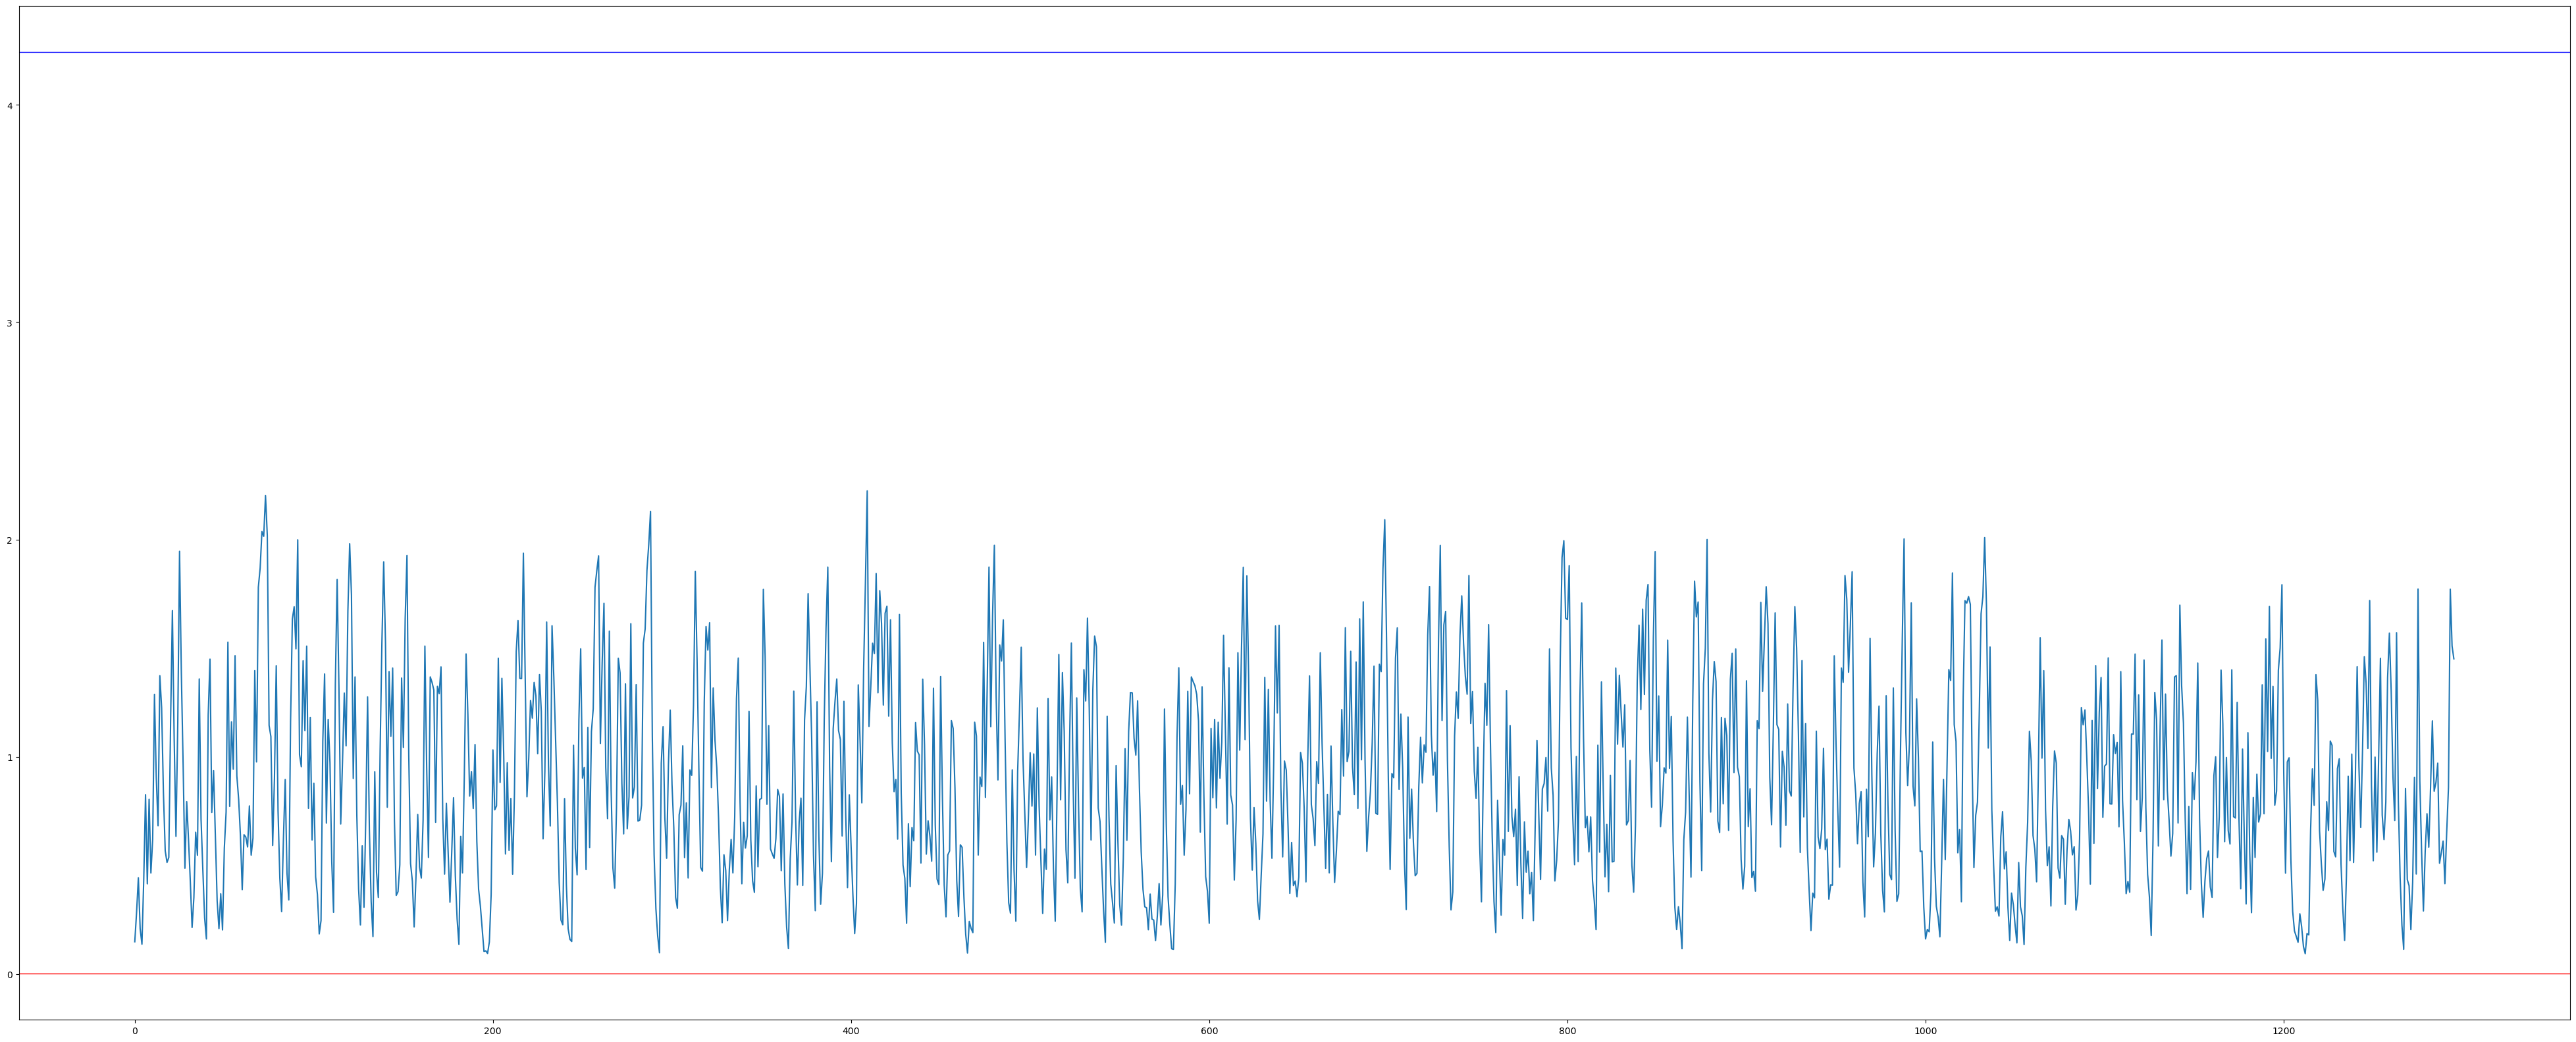

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1107, 7)
1


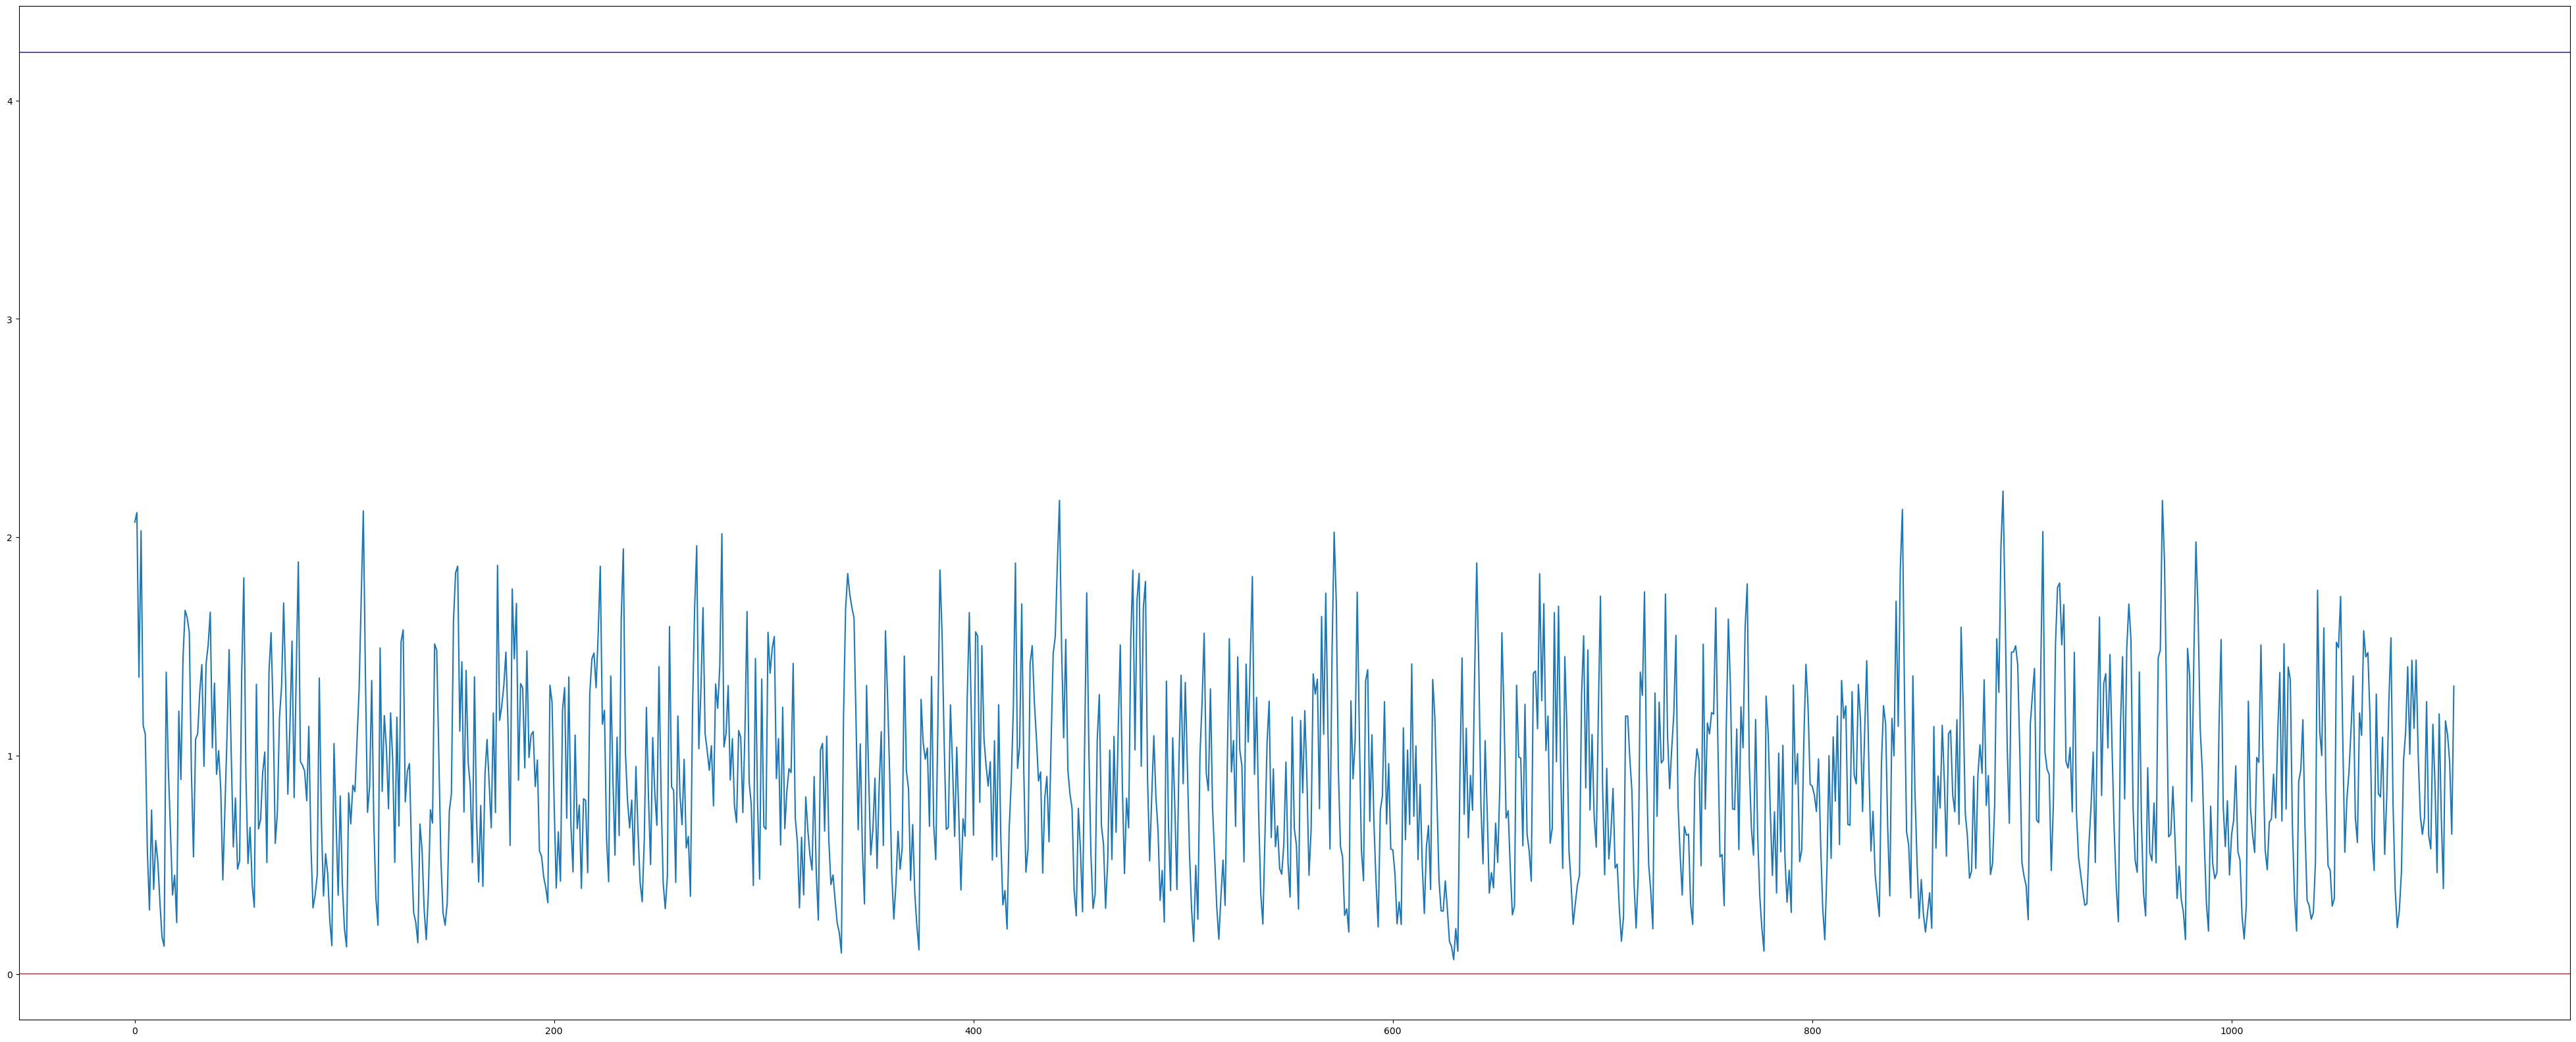

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1098, 7)
2


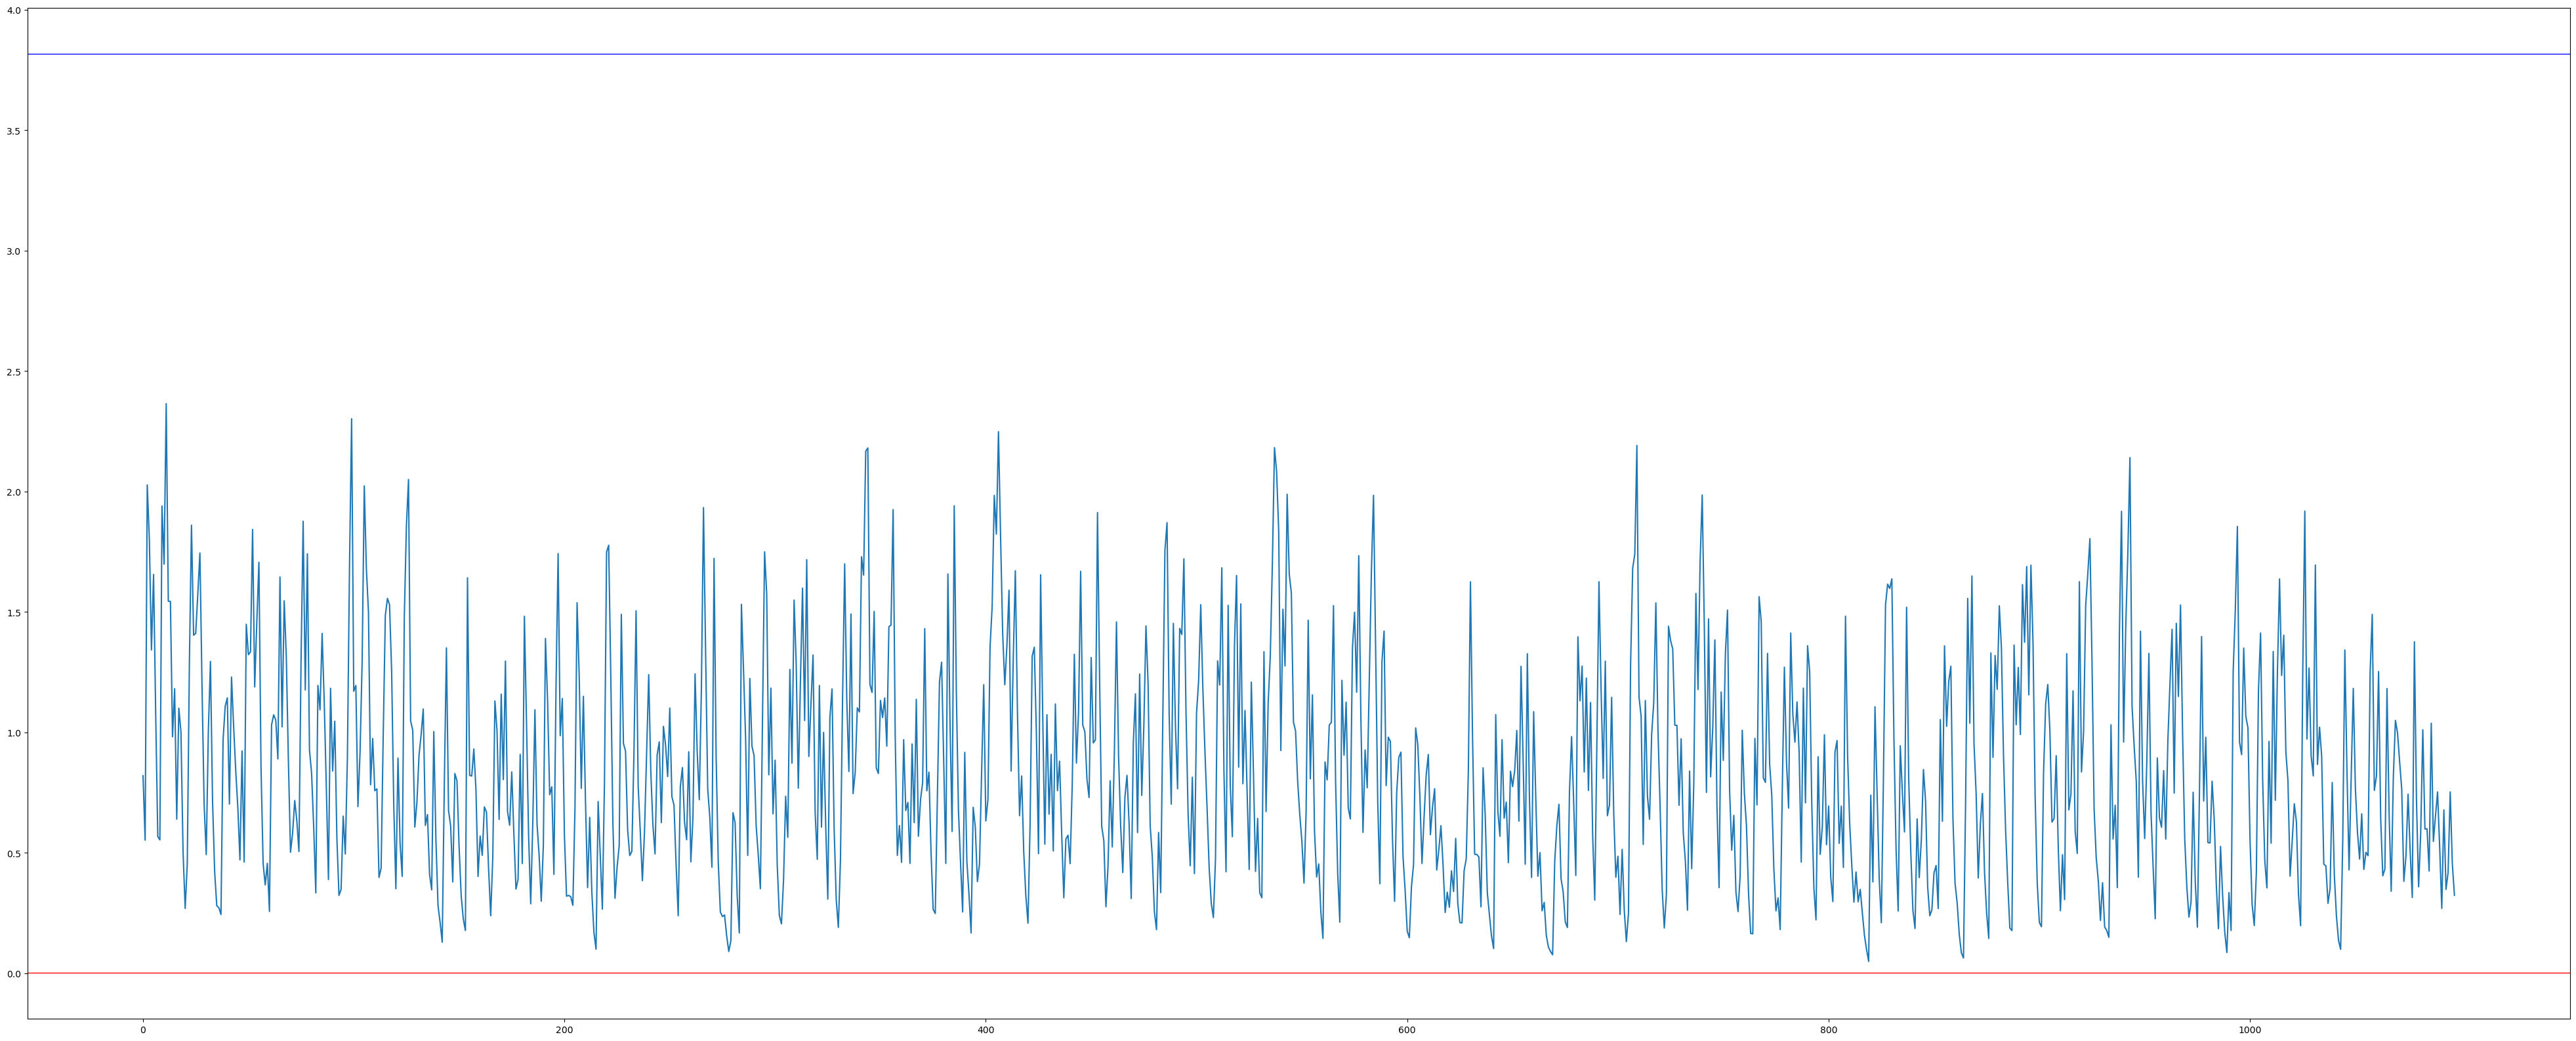

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(918, 7)
3


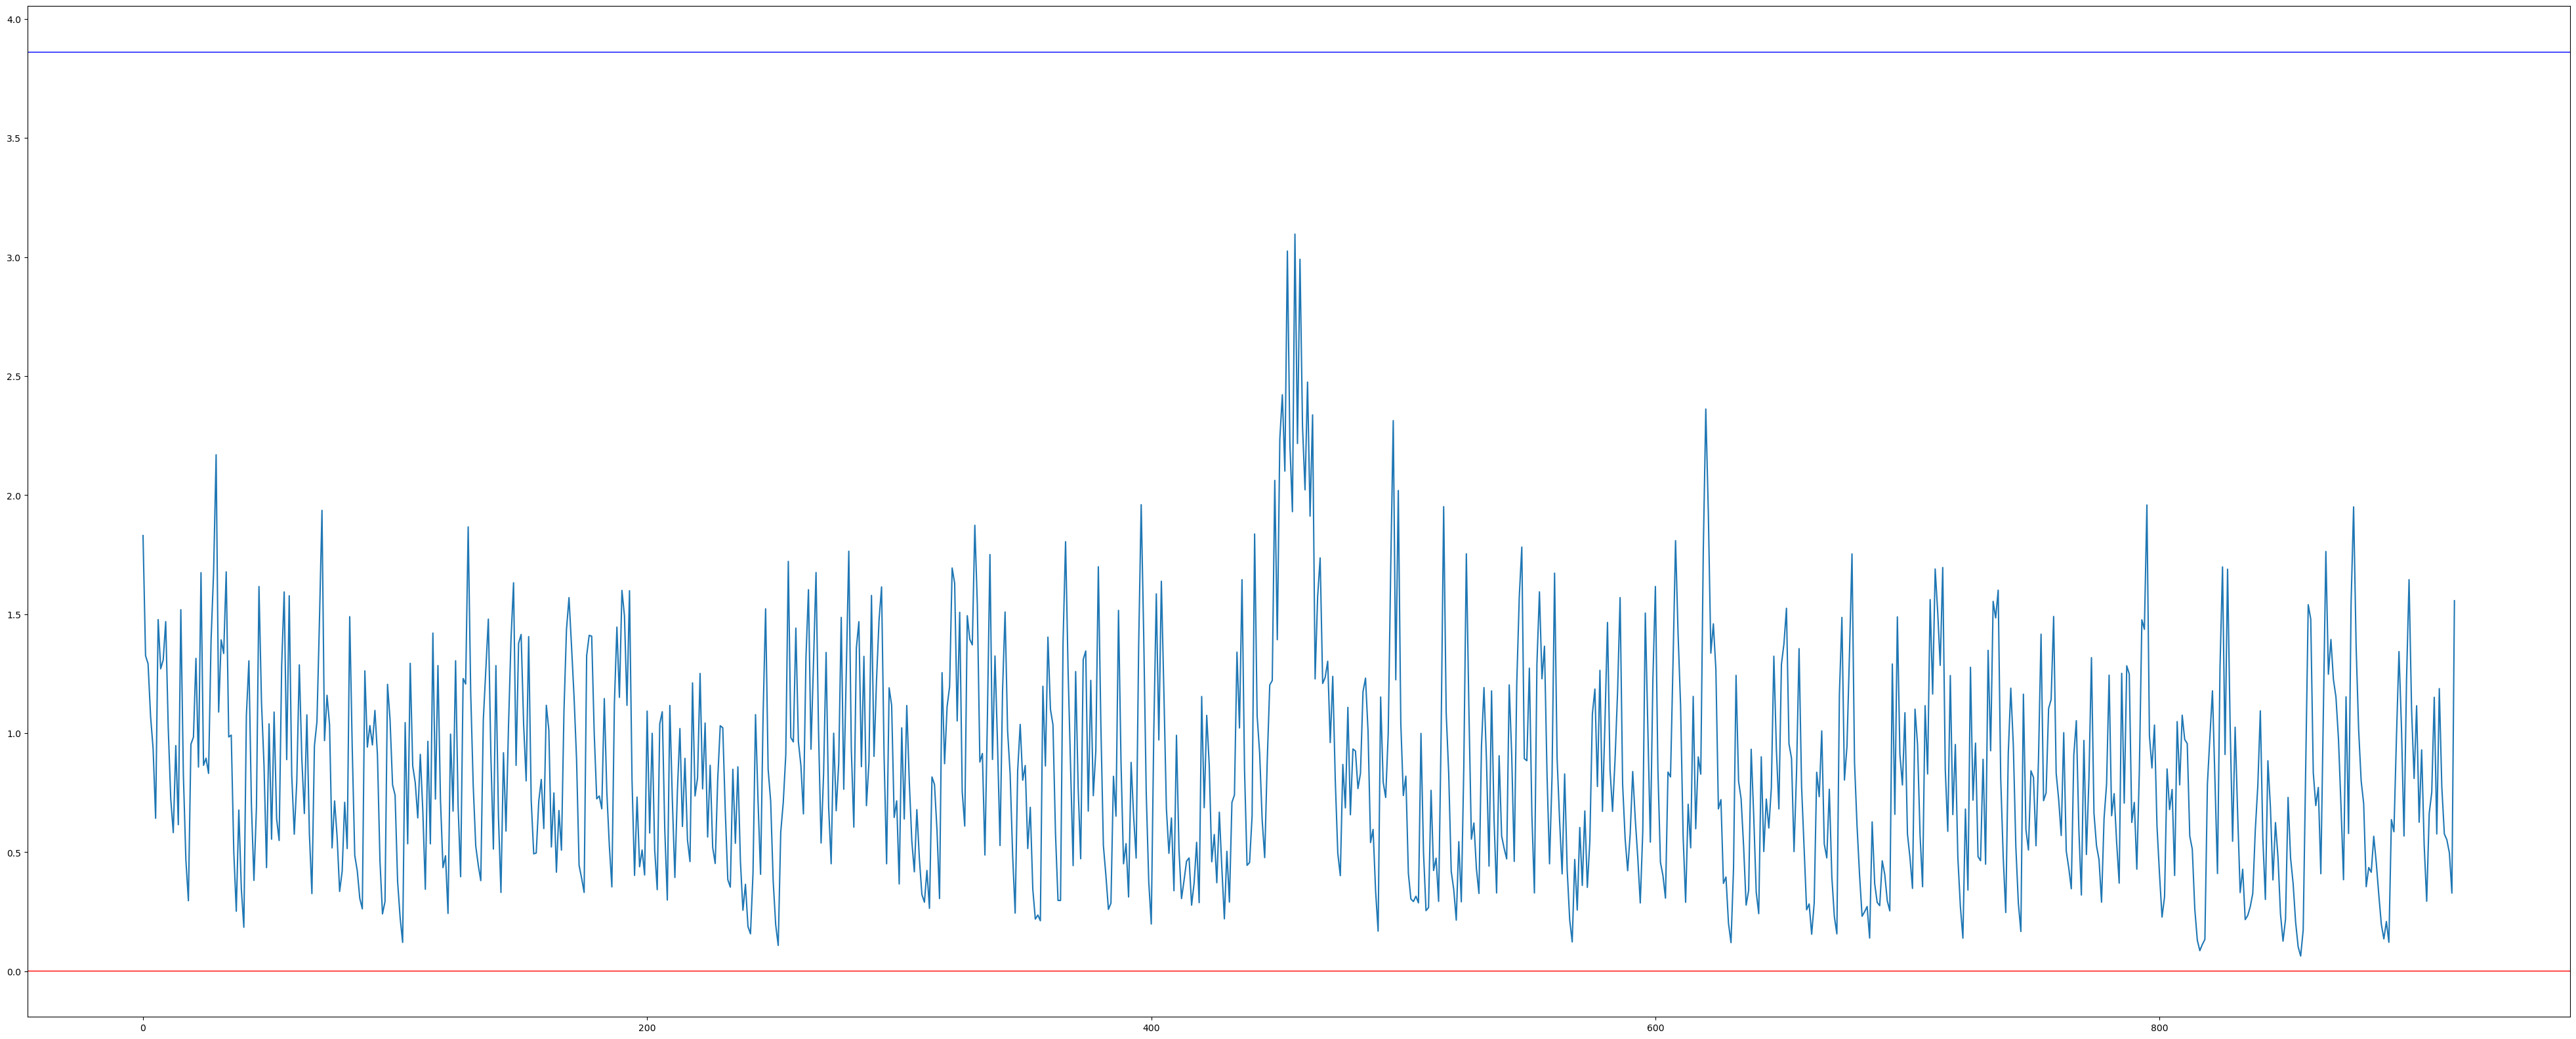

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(918, 7)
4


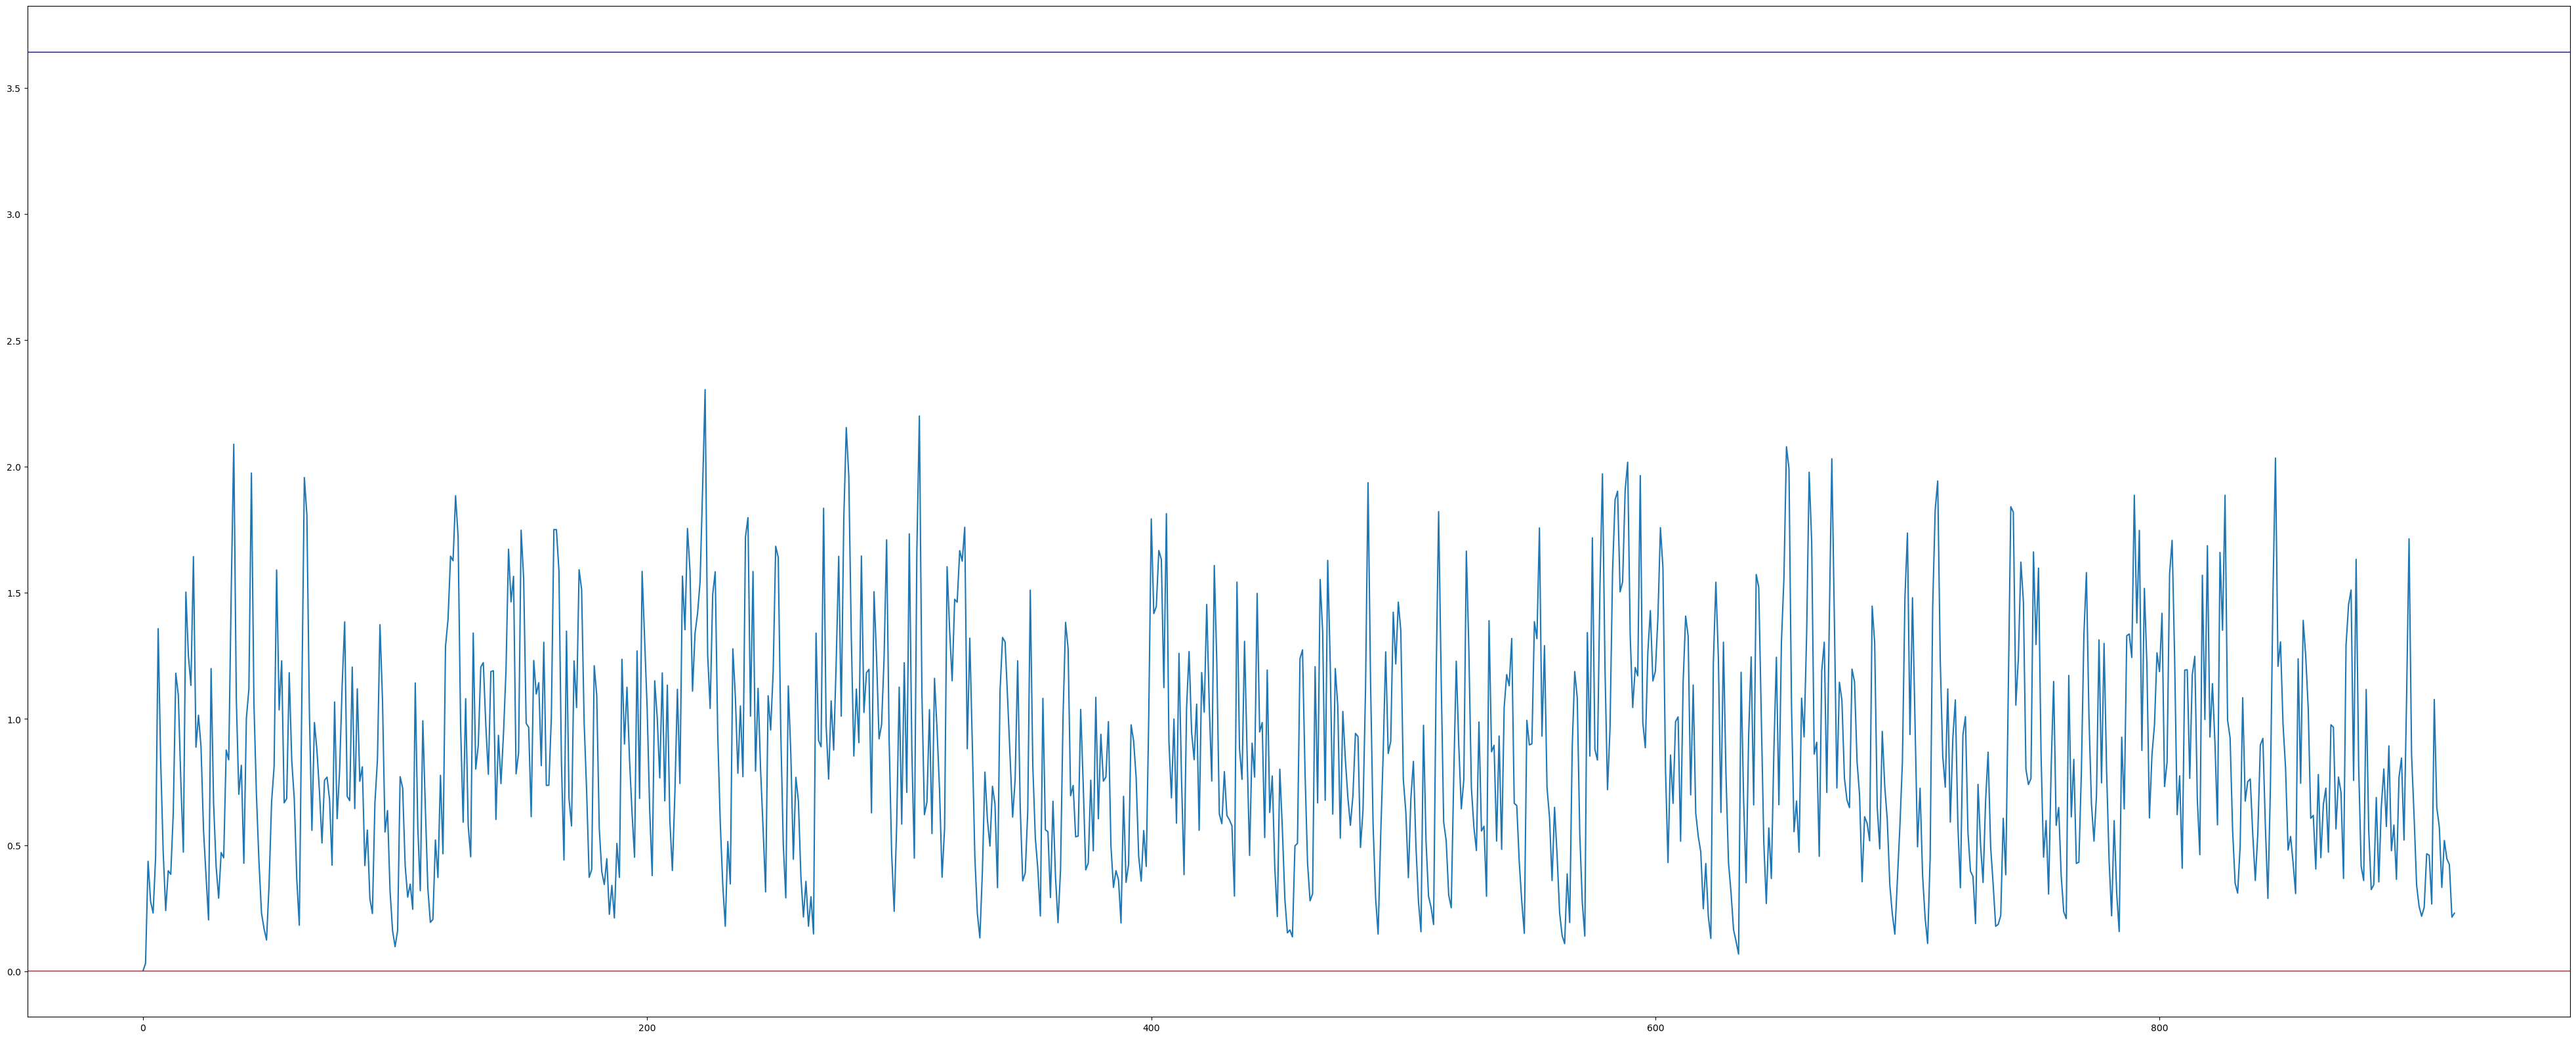

FileNotFoundError: [Errno 2] No such file or directory: './lstm_model_type5.pth'

In [154]:
pred = []
#threshold = [0.003, 0.003, 0.003, 0.003, 0.001, 0.003, 0.003, 0.003]
threshold = [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015]
for i in range(8):
    pretrained_model = torch.load('./' + MODEL_NAME+str(i)+'.pth')
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()
    summary(pretrained_model)

    test_type = test_df.loc[test_df['type']==i]
    test_data_drop = test_type.drop('type', axis=1)
    test_x = scaler_list[i].transform(test_data_drop)
    print(test_x.shape)

    test_dataset = MyDataset(making_model_input(test_x))
    test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
    print(i)
    #print(threshold)
    test_loss = []
    true = []
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x,_ = pretrained_model(x)
            true += x.detach().tolist()
            pred += _x.detach().tolist()
    true_2d = making_2d(true)
    pred_2d = making_2d(pred)
    error = true_2d - pred_2d
    
    mse_list = np.mean(np.power(error,2),axis=1)
    mse_list = pd.Series(mse_list).ewm(alpha=0.5).mean(10)
    plt.figure(figsize=(50,20))
    plt.plot(mse_list)
    #plt.ylim([0,1])
    plt.axhline(y=threshold[i], color='r', linewidth=1)
    plt.axhline(y=mean_loss_list[i], color='b', linewidth=1)
    plt.show()
    '''mse_arr = torch.tensor(mse_list)
    tmp = torch.where(mse_arr > threshold[i], 1, 0).detach().tolist()
    flag = 0
    
    if len(tmp) > 10:
        for idx in range(len(tmp)-10):
            for k in range(2,10):
                if tmp[idx]==1 and tmp[idx+k]==1:
                    for j in range(1,k):
                        tmp[idx+j] =1
                        
    elif len(tmp) <= 10 and len(tmp) > 2:
         for idx in range(len(tmp)):
            for k in range(2,len(tmp)-idx):
                if tmp[idx]==1 and tmp[idx+k]==1:
                    for j in range(1,k):
                        tmp[idx+j] =1
    
    #warm up
    if len(tmp) > 2:
        for idx in range(2, len(mse_arr)):
            if tmp[idx]==1 and mse_arr[idx-1] > mse_arr[idx-2] and mse_arr[idx-1] > mean_loss_list[i]:
                tmp[idx-1]=1

    #plt.show()
    print(Counter(tmp)) 
    plt.figure(figsize=(50,20))
    plt.plot(tmp)
    plt.show()


    pred += tmp'''


#train start

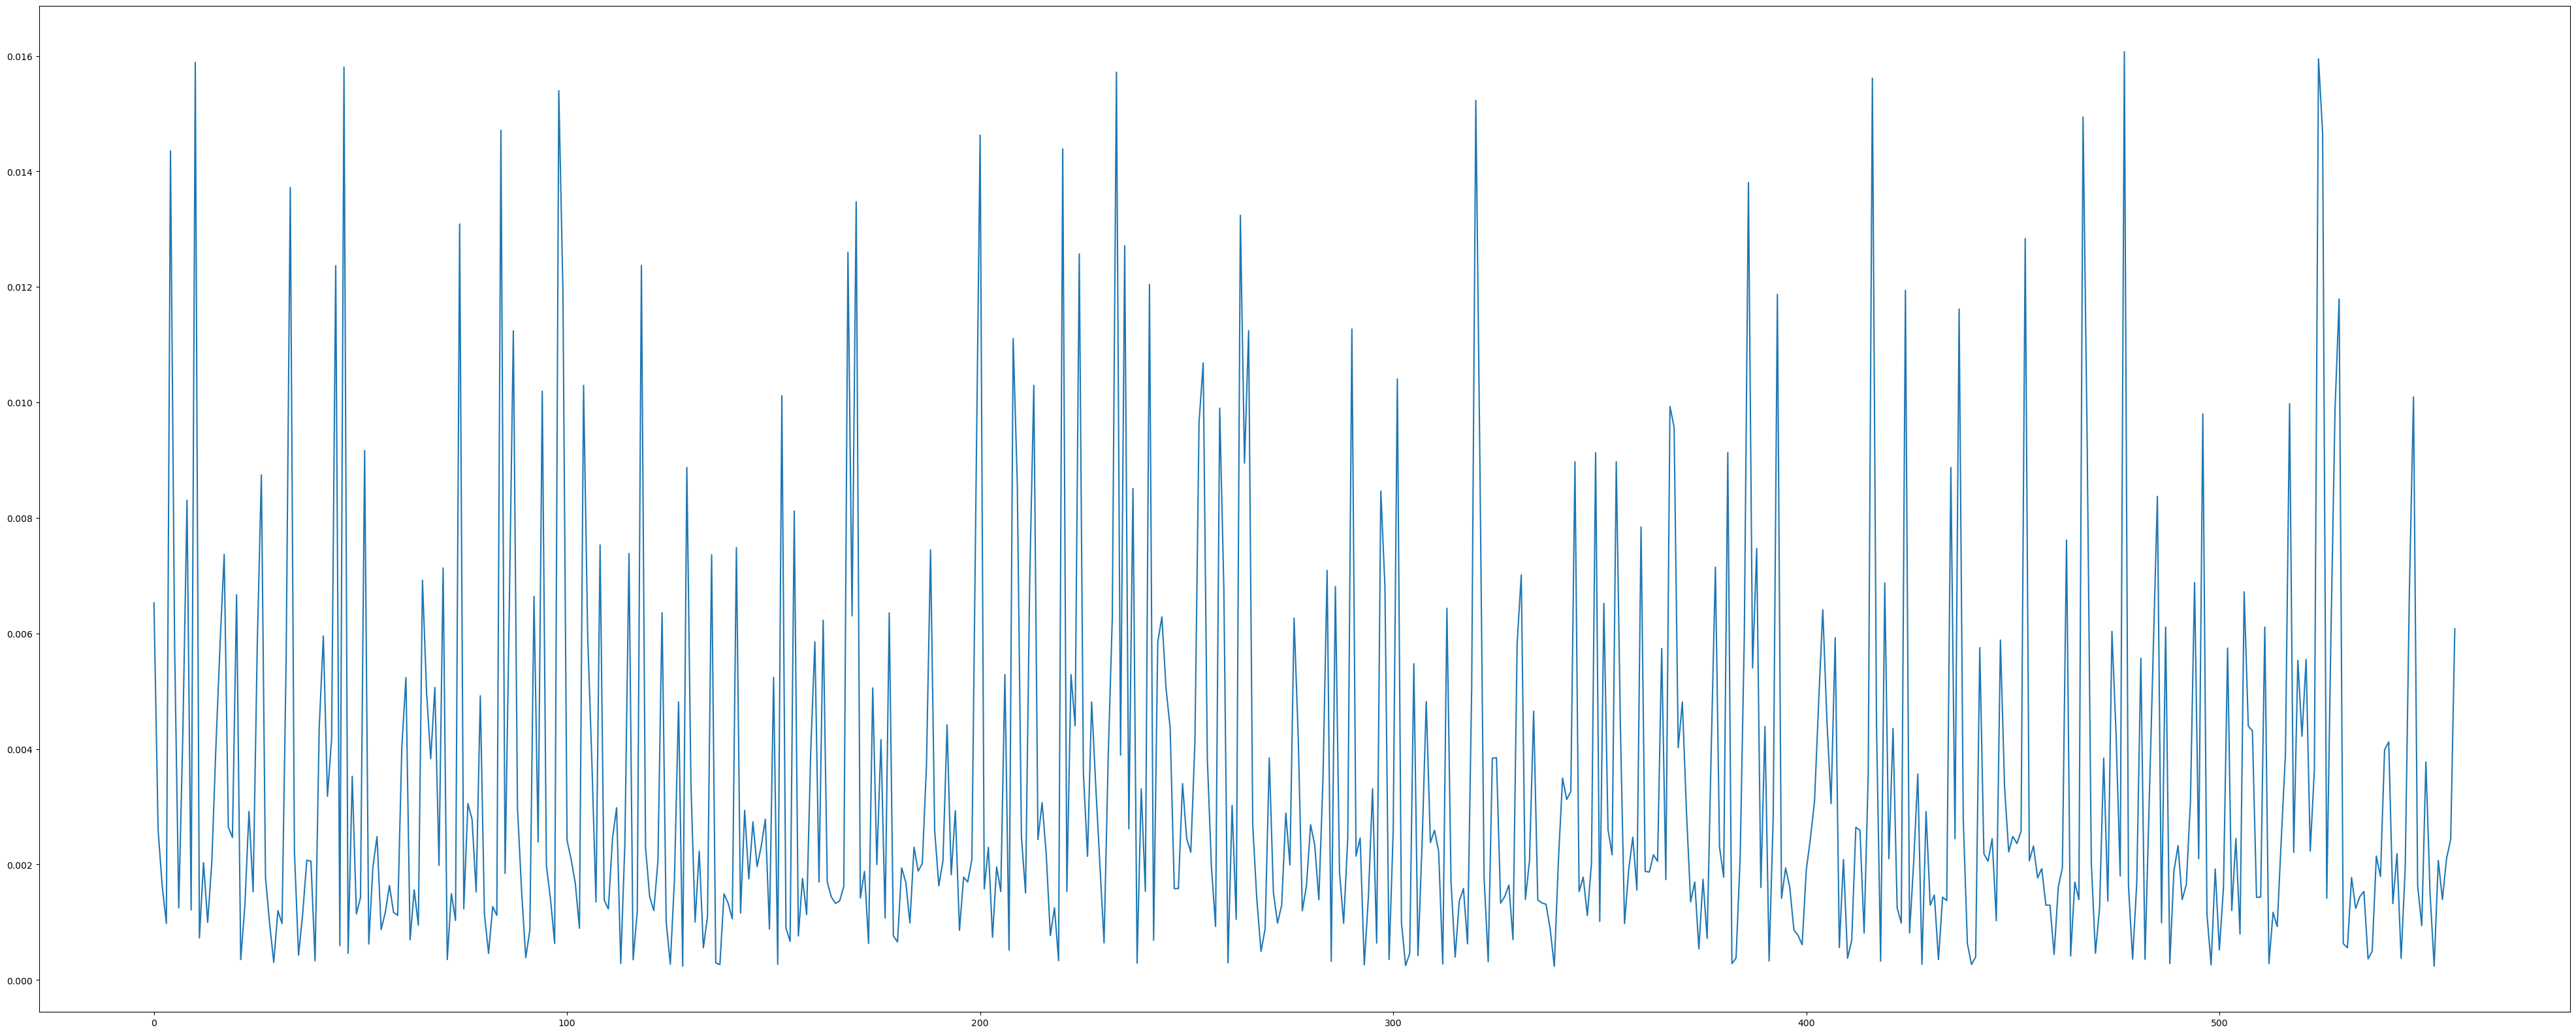

In [431]:
test_loss = []
mse_list = []
with torch.no_grad():
    for x in iter(test_loader):
        x = x.float().to(device)
        _x,_ = pretrained_model(x)
        error = x-_x
        mse = np.mean(np.power(error.numpy(),2),axis=1)
        mse_list.extend(mse)
plt.figure(figsize=(50,20))
plt.plot(mse_list)
plt.show()

for i in range(len(mse_list)):
    if mse_list[i]> 0.03:
        print(mse_list[i])